In [37]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import re
import itertools
from sklearn.preprocessing import MinMaxScaler
import os
import sys

# plt.style.use('../src/configs/figures.mplstyle')
plt.rcParams['axes.labelweight'] = 'bold'
palette = {'ICAT': '#d62728',
           'No Int.': '#A846A0',
           'Seurat 3.1': '#61D190',#'#8DCC78',
           'Seurat 3.1 + ICAT': '#0f783e',
           'Scanorama': '#72A1E5',
           'Scanorama + ICAT': '#273f87'}

method_dictionary = {
    'icat': 'ICAT',
    'seurat311': 'Seurat 3.1',
    'scanorama': 'Scanorama',
    'icat_scan': 'Scanorama + ICAT',
    'seurat_icat': 'Seurat 3.1 + ICAT',
    'no-int': 'No Int.',
}

label_order = ['ICAT', 'No Int.', 'Seurat 3.1',
               'Seurat 3.1 + ICAT', 'Scanorama','Scanorama + ICAT']

def format_method(name):
    if '+' in name:
        return name.replace(' +', '\n+')
    if name == 'No Integration':
        return 'No Int.'
    return name

# def label_order(x):
figdir = os.path.join('figures', 'simulated')
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [2]:

# plt.savefig('subfig_test2.png', bbox_inches='tight')

In [4]:
expected_clusters = {'SignalExperiment': 6, 'PerturbationExperiment': 6, 'ProportionExperiment': 5}

In [5]:
results = pd.read_csv('data/sim_results.csv', index_col=0)
def experiment_group(x):
    return re.sub('[0-9]', '', x)

def format_results(results):
    min_cells = {'ProportionExperiment1': 100,
                 'ProportionExperiment2': 75,
                 'ProportionExperiment3': 50}
    results.method.replace(method_dictionary, inplace=True)
    results.rename(columns={'method': 'Method', 'C1+.f1': 'F1-Stim'}, inplace=True)
    results['ExpType'] = results.apply(lambda x: experiment_group(x['Experiment']),
                                       axis=1)
    def number_of_cells(exptype):
        if exptype in min_cells.keys():
            return min_cells[exptype]
        return 100
    results['Min Cluster Size'] = results.apply(lambda x: number_of_cells(x['Experiment']), axis=1)
    
    results['Percent Perturbed'] *= 100

    results['cluster_dif'] = results.apply(lambda x: x['ncluster'] - expected_clusters[x['ExpType']],
                                           axis=1)
    results['F1-Unique'] = results.apply(lambda x: x[['P4.f1', 'P5.f1']].mean() ,
                                           axis=1)
    by_run = results.groupby(['Run'])
    results['Scaled_DB'] = MinMaxScaler().fit_transform(-1 * results['DB'].values.reshape(-1,1))
    return results
formatted = format_results(results)
formatted['Gini (Combined)'].unique()

array([0.       , 0.234375 , 0.1171875])

In [5]:
# formatted.groupby(['Experiment', 'Method'])['Scaled_DB'].mean()
formatted.columns

Index(['ARI', 'FM', 'ncluster', 'P5.f1', 'P4.f1', 'F1-Stim', 'C1.f1', 'C3.f1',
       'C2.f1', 'calinski', 'DB', 'Method', 'Experiment', 'Sim', 'Rep', 'Run',
       'LISI', 'Activated.LISI', 'Unnamed: 0.1', 'Markers (Total)',
       'Markers (%)', 'Total Average Marker Shift', 'Perturbation Shift',
       'Percent Perturbed', 'Markers (Mean)', 'Gini (Control)',
       'Gini (Perturbed)', 'Gini (Merged)', 'Gini (Combined)', 'ExpType',
       'Min Cluster Size', 'cluster_dif', 'F1-Unique', 'Scaled_DB'],
      dtype='object')

In [81]:
def lineplot(data, methods, x, y, exptype, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    rows = data.Method.isin(methods)
    view = data[rows]
    ax = sns.lineplot(x=x,y=y, hue='Method',
                 data=view[view.ExpType==exptype], ci=95,
                 palette=palette, ax=ax, **kwargs)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    return ax

In [7]:
data = formatted
experiments = ['PerturbationExperiment', 'SignalExperiment']
methods = ['ICAT', 'Seurat 3.1', 'Scanorama', 'No Int.']

In [86]:
def signal_pert_plot(data, metrics=['ARI', 'LISI', 'cluster_dif', 'F1-Stim', 'Scaled_DB'],
                     methods=['ICAT', 'No Int.', 'Seurat 3.1', 'Scanorama']):

    labels = {'ARI': 'ARI',
              'F1-Stim': "F1-Stim",
              'cluster_dif': '# Clusters\n- Expected',
              'LISI': 'LISI',
              'Scaled_DB': 'DB',
              'F1-Unique':'F1-\nUnique'}
    experiments = ['PerturbationExperiment', 'SignalExperiment']
    selected = data[data.apply(lambda x: x['ExpType'] in experiments and x['Method'] in methods,
                     axis=1)]
    ymins = selected[metrics].min()
    ymaxs = selected[metrics].max()
    fig, axes = plt.subplots(len(metrics), 2, figsize=(6, 12))
    for j, exp in enumerate(experiments):
        for i, metric in enumerate(metrics):
            plot_methods = methods
            if metric in ['F1-Stim', 'Scaled_DB', 'F1-Unique']:
                plot_methods = [x for x in methods if x != 'No Int.']
            x = 'Percent Perturbed'
            if exp == 'SignalExperiment':
                x = 'Markers (Mean)'
            axes[i, j] = lineplot(selected, plot_methods, x, metric, exp, ax=axes[i, j],
                                  hue_order=plot_methods[::-1])
            axes[i, j].set_ylim(ymins[metric] - 0.05, ymaxs[metric] + 0.05)
            if j == 1:
                axes[i, j].set_ylabel('')
                axes[i, j].set_yticklabels([])
            else:
                axes[i, j].set_ylabel(labels[metric])
                if metric == 'LISI':
                    axes[i, j].set_yticks([0, 1])
                    axes[i, j].set_yticklabels([0, 1])
            if i == 0 and j == 0:
                axes[i, j].legend_.set_visible(False)
                axes[i, j].annotate('A', (-0.4, 1),
                                    xycoords='axes fraction',
                                    fontsize=36)
            elif i == 0 and j == 1:
                # legend order reverse from plotting order
                h, l = axes[i, j].get_legend_handles_labels()
                l = [format_method(x) for x in l]
                axes[i, j].legend_.remove()
                axes[i, j].legend([h[0]] + h[1:][::-1],
                                  [l[0]] + l[1:][::-1],
                                  bbox_to_anchor=((1.05, 1.1)))
                axes[i, j].legend_.set_bbox_to_anchor((1.05, 1.1))
                axes[i, j].annotate('B', (-0.1725, 1),
                                    xycoords='axes fraction',
                                    fontsize=36)
            else:
                axes[i, j].legend_.set_visible(False)
            if i != len(metrics) - 1:
                axes[i, j].set_xlabel('')
                axes[i, j].set_xticklabels([])
            elif j == 0:
                axes[i, j].set_xlabel('Perturbed\nGenes (%)')
            else:
                axes[i, j].set_xlabel('Markers\n(Mean)')

    fig.subplots_adjust(wspace=0.2)#, top=0.85, bottom=0.05)
    return fig, axes

In [79]:
import matplotlib.lines as mlines
import string
def rename(x):
    if '+' not in x:
        return x
#     return x.replace(' ', '').replace('+', '\n+')
    if 'Scan' in x:
        x='Scan'
    return "ICAT$_{" + x.split(' ')[0] + '}$'

def ncluster_plot(data,
                  methods=[['ICAT', 'No Int.', 'Seurat 3.1', 'Scanorama'],
                           ['ICAT', 'Seurat 3.1', 'Seurat 3.1 + ICAT'],
                           ['ICAT', 'Scanorama', 'Scanorama + ICAT']],
                  fig=None):

    labels = {'ARI': 'ARI',
              'F1-Stim': "F1-Stim",
              'cluster_dif': '# Clusters\n- Expected',
              'LISI': 'LISI',
              'Scaled_DB': 'DB',
              'F1-Unique':'F1-\nUnique'}
    experiments = ['PerturbationExperiment', 'SignalExperiment']
    selected = data[data['ExpType'].isin(experiments)]
    metric = 'cluster_dif'
    ymin = selected[metric].min()
    ymax = selected[metric].max()
    if fig is None:
        fig, axes = plt.subplots(len(methods), 2, figsize=(4, 6))
    for j, exp in enumerate(experiments):
        for i, plot_methods in enumerate(methods):
            x = 'Percent Perturbed'
            if exp == 'SignalExperiment':
                x = 'Markers (Mean)'
            axes[i, j] = lineplot(selected, plot_methods, x, metric, exp, ax=axes[i, j],
                                  hue_order=plot_methods[::-1])
            if i > 0:
              axes[i, j].set_ylim(-4, 1.5)
#             axes[i, j].set_ylim(ymin - 0.05, ymax + 0.05)
            if j == 1:
                axes[i, j].set_ylabel('')
                axes[i, j].set_yticks([])
            else:
                axes[i, j].set_ylabel(labels[metric])
                axes[i, j].annotate(string.ascii_uppercase[i],
                                    xy=(-0.3, 0.95),
                                    xycoords='axes fraction',
                                    fontsize=22,
                                    fontweight='bold')
            if i == 0 and j == 1:
                axes[i, j].legend_.remove()
                pop_handles = [mlines.Line2D([], [], color=palette[x], marker='', linewidth=2,
#                                  markersize=5,
                             label=x) for x in palette]
#                              if key!='P(C1)']
                axes[i, j].legend(pop_handles, [rename(x) for x in palette.keys()],
                           markerscale=1.5,
                           bbox_to_anchor=(1, 1),
            #                title_fontsize=12,
                           fontsize=10,
                           ncol=1,
                           columnspacing=0, handletextpad=0.25, labelspacing=0)
            else:
                axes[i, j].legend_.set_visible(False)
            if i != len(methods) - 1:
                axes[i, j].set_xlabel('')
                axes[i, j].set_xticks([])
            elif j == 0:
                axes[i, j].set_xlabel('Perturbed\nGenes (%)')
                axes[i, j].set_xticks([0, 25])
            else:
                axes[i, j].set_xlabel('Markers\n(Mean)')
                axes[i, j].set_xticks([0, 50, 100])

    fig.subplots_adjust(wspace=0.2)#, top=0.85, bottom=0.05)
    return fig, axes

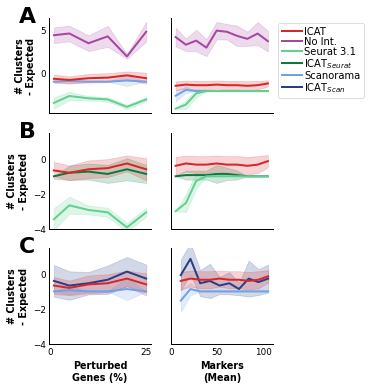

In [82]:

rc = {"xtick.major.pad": 0,
      "ytick.major.pad": 0,
      "xtick.major.size": 0,
      "xtick.minor.size": 0,
      "ytick.major.size": 0,
      "ytick.minor.size": 0,
      "lines.linewidth": 2,
      "figure.subplot.left": 0.08,
      "figure.subplot.right": 0.95,
      "figure.subplot.bottom": 0.07,
      "figure.subplot.wspace": 0.25,
      "figure.subplot.hspace": 0.25,
      "legend.labelspacing": 0,
      "legend.handletextpad": 0,
      "legend.columnspacing": 0,
      "font.family": "san-serrif"}


with sns.plotting_context("paper", font_scale=1, rc=rc):
    fig, axes = ncluster_plot(formatted)
#     plt.savefig('figures/nclusters.svg', bbox_inches='tight', dpi=200)

In [84]:
def signal_pert_plot_embedded(data, metrics=['ARI', 'LISI', 'cluster_dif', 'F1-Stim', 'Scaled_DB'],
                              methods=['ICAT', 'No Int.', 'Seurat 3.1', 'Scanorama'],
                              fig=None):

    labels = {'ARI': 'ARI',
              'F1-Stim': "F1-Stim",
              'cluster_dif': '# Clusters\n- Expected',
              'LISI': 'LISI',
              'Scaled_DB': 'DB',
              'F1-Unique':'F1-\nUnique'}
    experiments = ['PerturbationExperiment', 'SignalExperiment']
    selected = data[data.apply(lambda x: x['ExpType'] in experiments and x['Method'] in methods,
                     axis=1)]
    ymins = selected[metrics].min()
    ymaxs = selected[metrics].max()
    if fig is None:
        fig, axes = plt.subplots(len(metrics), 2, figsize=(6, 12))
    else:
        axes = fig.subplots(len(metrics), 2)
    for j, exp in enumerate(experiments):
        for i, metric in enumerate(metrics):
            plot_methods = methods
            if metric in ['F1-Stim', 'Scaled_DB', 'F1-Unique']:
                plot_methods = [x for x in methods if x != 'No Int.']
            x = 'Percent Perturbed'
            if exp == 'SignalExperiment':
                x = 'Markers (Mean)'
            axes[i, j] = lineplot(selected, plot_methods, x, metric, exp, ax=axes[i, j],
                                  hue_order=plot_methods[::-1])
            axes[i, j].set_ylim(ymins[metric] - 0.05, ymaxs[metric] + 0.05)
            if j == 1:
                axes[i, j].set_ylabel('')
                axes[i, j].set_yticks([])
            else:
                axes[i, j].set_ylabel(labels[metric])
                if metric != 'cluster_dif':
                    axes[i, j].set_yticks([0, 1])
            if i == 0 and j == 0:
                axes[i, j].legend_.set_visible(False)
#                 axes[i, j].annotate('A', (-0.4, 1),
#                                     xycoords='axes fraction',
#                                     fontsize=36)
            elif i == 0 and j == 1:
                # legend order reverse from plotting order
                h, l = axes[i, j].get_legend_handles_labels()
                l = [format_method(x) for x in l]
                axes[i, j].legend_.remove()
                axes[i, j].legend([h[0]] + h[1:][::-1],
                                  [l[0]] + l[1:][::-1],
                                  bbox_to_anchor=((1.05, 1.1)))
                axes[i, j].legend_.set_bbox_to_anchor((1.05, 1.1))
#                 axes[i, j].annotate('B', (-0.1725, 1),
#                                     xycoords='axes fraction',
#                                     fontsize=36)
#             else:
            axes[i, j].legend_.set_visible(False)
            if i != len(metrics) - 1:
                axes[i, j].set_xlabel('')
                axes[i, j].set_xticks([])
            elif j == 0:
                axes[i, j].set_xlabel('Perturbed\nGenes (%)')
                axes[i, j].set_xticks([0, 25])
            else:
                axes[i, j].set_xlabel('Markers\n(Mean)')
                axes[i, j].set_xticks([0, 50, 100])

    fig.subplots_adjust(wspace=0.2)#, top=0.85, bottom=0.05)
    return fig, axes

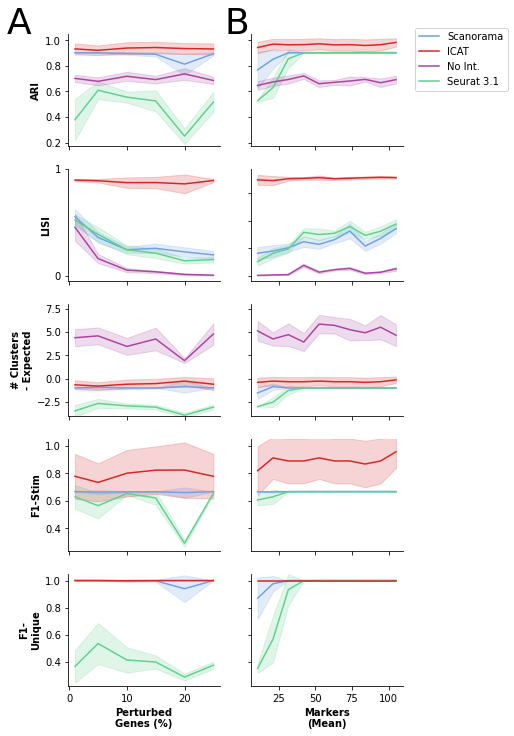

In [88]:
fig, axes = signal_pert_plot(formatted,
                             metrics=['ARI', 'LISI', 'cluster_dif', 'F1-Stim', 'F1-Unique'],
                             )
# plt.savefig(os.path.join(figdir, 'main_method_trendplots.svg'),
#             bbox_inches='tight')
# get figures finalized with legends
# two weeks, drafts of figures with legend + results section
# four weeks, everything else
# six weeks final draft

In [ ]:
def n_cluster_plot(data,
                   methods=[['ICAT', 'No Int.', 'Seurat 3.1', 'Scanorama'],
                            ['ICAT', 'Seurat 3.1', 'Seurat 3.1 + ICAT'],
                            ['ICAT', 'Scanorama', 'Scanorama + ICAT']],
                   fig=None):

    labels = {'ARI': 'ARI',
              'F1-Stim': "F1-Stim",
              'cluster_dif': '# Clusters\n- Expected',
              'LISI': 'LISI',
              'Scaled_DB': 'DB',
              'F1-Unique':'F1-\nUnique'}
    experiments = ['PerturbationExperiment', 'SignalExperiment']
    selected = data[data['ExpType'].isin(experiments)]
    ymins = selected[metrics].min()
    ymaxs = selected[metrics].max()
    metric = 'cluster_dif'
    if fig is None:
        fig, axes = plt.subplots(len(metrics), 2, figsize=(6, 12))
    else:
        axes = fig.subplots(len(methods), 2)
    for j, exp in enumerate(experiments):
        for i, plot_methods in enumerate(methods):
            x = 'Percent Perturbed'
            if exp == 'SignalExperiment':
                x = 'Markers (Mean)'
            axes[i, j] = lineplot(selected, plot_methods, x, metric, exp, ax=axes[i, j],
                                  hue_order=plot_methods[::-1])
            axes[i, j].set_ylim(ymins[metric] - 0.05, ymaxs[metric] + 0.05)
            if j == 1:
                axes[i, j].set_ylabel('')
                axes[i, j].set_yticks([])
            else:
                axes[i, j].set_ylabel(labels[metric])
                if metric != 'cluster_dif':
                    axes[i, j].set_yticks([0, 1])
            if i == 0 and j == 0:
                axes[i, j].legend_.set_visible(False)
#                 axes[i, j].annotate('A', (-0.4, 1),
#                                     xycoords='axes fraction',
#                                     fontsize=36)
            elif i == 0 and j == 1:
                # legend order reverse from plotting order
                h, l = axes[i, j].get_legend_handles_labels()
                l = [format_method(x) for x in l]
                axes[i, j].legend_.remove()
                axes[i, j].legend([h[0]] + h[1:][::-1],
                                  [l[0]] + l[1:][::-1],
                                  bbox_to_anchor=((1.05, 1.1)))
                axes[i, j].legend_.set_bbox_to_anchor((1.05, 1.1))
#                 axes[i, j].annotate('B', (-0.1725, 1),
#                                     xycoords='axes fraction',
#                                     fontsize=36)
#             else:
            axes[i, j].legend_.set_visible(False)
            if i != len(metrics) - 1:
                axes[i, j].set_xlabel('')
                axes[i, j].set_xticks([])
            elif j == 0:
                axes[i, j].set_xlabel('Perturbed\nGenes (%)')
                axes[i, j].set_xticks([0, 25])
            else:
                axes[i, j].set_xlabel('Markers\n(Mean)')
                axes[i, j].set_xticks([0, 50, 100])

    fig.subplots_adjust(wspace=0.2)#, top=0.85, bottom=0.05)
    return fig, axes

In [11]:
def signal_pert_plot_extend(data, methods=['Seurat 3.1', 'Seurat 3.1 + ICAT',
                                           'Scanorama', 'Scanorama + ICAT', 'ICAT']):
    labels = {'ARI': 'ARI',
              'F1-Stim': "F1-Stim",
              'cluster_dif': '# Clusters\n- Expected',
              'LISI': 'LISI',
              'Scaled_DB': 'DB',
              'F1-Unique':'F1-\nUnique'}
    experiments = ['PerturbationExperiment', 'SignalExperiment']
    metrics = ['ARI', 'LISI', 'cluster_dif','F1-Stim', 'F1-Unique']
    rows = len(metrics)
#     fig = plt.figure(figsize=(8, 2 * rows + 2))
    fig = plt.figure(figsize=(6, 12))
    gs = fig.add_gridspec(rows, 2)
    gs01 = gs[0:rows, 0].subgridspec(rows, 2)
    gs02 = gs[0:rows, 1].subgridspec(rows, 2)
    selected = data[data.apply(lambda x: x['ExpType'] in experiments and x['Method'] in methods,
                     axis=1)].copy()
    ymins = selected[metrics].min()
    ymaxs = selected[metrics].max()
#     ymaxs.at['C1+.f1'] = 0.75
    ymaxs.at['cluster_dif'] = 1
    lpatches = []
    llabels = []
    legend_ax = None
    for j, exp in enumerate(experiments):
        for i, metric in enumerate(metrics):
            for k, plot_methods in enumerate([['Seurat 3.1', 'Seurat 3.1 + ICAT', 'ICAT'],
                                              ['Scanorama', 'Scanorama + ICAT', 'ICAT']]):
                current_gs = gs01
                if j == 1:
                    current_gs = gs02
                ax = fig.add_subplot(current_gs[i, k])
                x = 'Percent Perturbed'
                if exp == 'SignalExperiment':
                    x = 'Markers (Mean)'
#                 if metric == 'F1(Asymetric)':
#                     plot_methods = [x for x in plot_methods if x != 'ICAT']
                ax = lineplot(selected, plot_methods, x, metric, exp, ax=ax,
                              hue_order=plot_methods)

                chandles, clabels = ax.get_legend_handles_labels()
                for h, l in zip(chandles, clabels):
                    if l not in llabels:
                        lpatches.append(h)
                        llabels.append(l)
                if i == 0 and j == 1 and k == 1:
                    legend_ax = ax
                    legend_ax.legend(lpatches, llabels)
                    legend_ax.legend_.set_visible(True)
                ax.legend_.remove()
                ax.set_ylim(ymins[metric] - 0.05, ymaxs[metric] + 0.05)
                if j == 1 or k == 1:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])
                else:
                    ax.set_ylabel(labels[metric])
                if i != len(metrics) - 1:
                    ax.set_xlabel('')
                    ax.set_xticklabels([])
                elif k == 1:
                    ax.set_xlabel('')
                elif j == 0:
                    ax.set_xlabel('Perturbed\nGenes (%)')
                elif j == 1:
                    ax.set_xlabel('Markers\n(Mean)')
                    
                if i == 0 and j == 0 and k == 0:
                    ax.annotate('A', (-0.75, 1),
                                        xycoords='axes fraction',
                                        fontsize=36)
                elif i == 0 and j == 1 and k == 0:
                    ax.annotate('B', (-0.5, 1),
                                        xycoords='axes fraction',
                                        fontsize=36)
    hard_coded_order = [0, 3, 1 , 2, 4, 5]
    llabels = [format_method(x) for x in llabels]
    legend_ax.legend(np.array(lpatches)[hard_coded_order],
                     np.array(llabels)[hard_coded_order],
                     bbox_to_anchor=(1, 1.05))
    legend_ax.legend_.set_visible(True)
#     fig.subplots_adjust(wspace=0.2)#, top=0.85, bottom=0.05)
    return fig

In [87]:
# plt.cla()
# plt.clf()
# plt.close()
fig = signal_pert_plot_extend(formatted)
# plt.savefig(os.path.join(figdir, 'extended_method_trendplots.svg'))
plt.show()

NameError: name 'signal_pert_plot_extend' is not defined

In [13]:


def rare_cell_plot(data, methods=['ICAT', 'Seurat 3.1', 'Scanorama'], fig=None):
    # ARI , F1(Rare)
    # methods
    # seurat
    # scan 
    metrics = ['ARI', 'F1-Rare', 'cluster_dif']
    plot_labels = {'ARI': 'ARI',
                   'cluster_dif': '# Clusters\n- Expected',
                   'F1-Rare': 'F1-\nRare'}
    if fig is None:
        fig, axes = plt.subplots(len(metrics), 3, figsize=(8,6))
    else:
        axes = fig.subplots(len(metrics), 3)
    experiments = ['ProportionExperiment']
    row_methods = [methods[::-1],
                  ['ICAT', 'Seurat 3.1', 'Seurat 3.1 + ICAT'][::-1],
                  ['ICAT','Scanorama', 'Scanorama + ICAT'][::-1]]
    selected = data[data.apply(lambda x: x['ExpType'] in experiments, axis=1)].copy()
    selected['F1-Rare'] = selected.apply(lambda x: np.mean(x[['C1.f1', 'P4.f1']]), axis=1)
    lpatches = []
    llabels = []
    
    ymins = selected[metrics].min()
    ymaxs = selected[metrics].max()
    ymaxs['cluster_dif'] = 4
    ymins['cluster_dif'] = -5
#     x = 'Min Cluster Size'
    x = 'Gini (Combined)'
    for j, to_plot in enumerate(row_methods):
        for i, metric in enumerate(metrics):
            axes[i, j] = lineplot(selected, to_plot, x, metric, 'ProportionExperiment',
                                  ax=axes[i,j], hue_order=to_plot)
            if i == 0 and j == 0:
                axes[i, j].annotate('A', (-0.5, 1),
                            xycoords='axes fraction',
                            fontsize=36)
            elif i == 0 and j != 0:
                sublabels = {1: 'B', 2: 'C'}
                axes[i, j].annotate(sublabels[j], (-0.25, 1),
                            xycoords='axes fraction',
                            fontsize=36)
            if x == 'Min Cluster Size':
                axes[i, j].set_xticks([50, 75, 100][::-1])
                axes[i, j].set_xlim(105, 45)
            handles, labels = axes[i, j].get_legend_handles_labels()
#             labels = [str(x) for x in labels]
            axes[i, j].set_ylabel(plot_labels[metric])
            for h, l in zip(handles, labels):
                if l not in llabels:
                    lpatches.append(h)
                    llabels.append(l)
            axes[i, j].legend_.set_visible(False)
            if i != len(metrics) - 1:
                axes[i, j].set_xlabel('')
                axes[i, j].set_xticklabels([])
            elif j != 1:
                axes[i, j].set_xlabel('')
            if j != 0:
                axes[i, j].set_ylabel('')
                axes[i, j].set_yticklabels([])
            elif metric == 'cluster_dif':
                axes[i, j].set_yticks([-4, -2, 0, 2, 4])
            axes[i, j].set_ylim(ymins[metric] - 0.05, ymaxs[metric] + 0.05)
            
#     lineplot(data, methods, x, y, exptype, ax=None):
    reorder_h = []
    reorder_l = []
    for l in label_order:
        if l in llabels:
            idx = np.where(np.array(llabels)==l)[0][0]
            reorder_h.append(lpatches[idx])
            reorder_l.append(format_method(l))
    axes[0, -1].legend_.remove()
    axes[0, -1].legend(reorder_h, reorder_l, bbox_to_anchor=(1, 1.05))
    return fig, axes

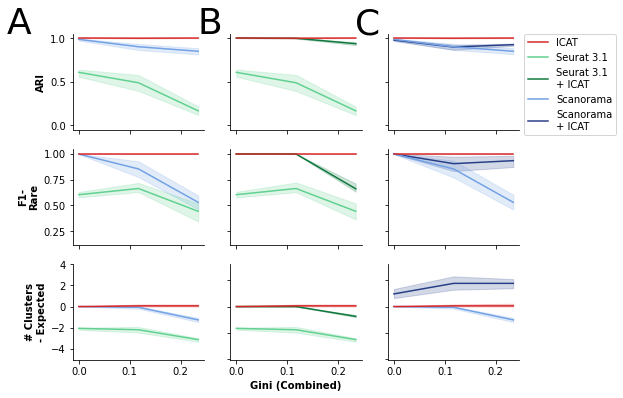

In [14]:
rare_cell_plot(formatted)
# plt.savefig(os.path.join(figdir, 'rare_cell_trendplots.svg'))
plt.show()
# plt.show()
# formatted['Min. Cells']
# formatted['Min. Cells'].hist()

In [15]:

def rare_cell_plot_embedded(data, methods=['ICAT', 'Seurat 3.1', 'Scanorama'], fig=None):
    # ARI , F1(Rare)
    # methods
    # seurat
    # scan 
    metrics = ['ARI', 'F1-Rare', 'cluster_dif']
    metrics = ['ARI', 'F1-Rare']
    plot_labels = {'ARI': 'ARI',
                   'cluster_dif': '# Clusters\n- Expected',
                   'F1-Rare': 'F1-Rare'}
    if fig is None:
        fig, axes = plt.subplots(len(metrics), 3, figsize=(8,6))
    else:
        axes = fig.subplots(len(metrics), 3)
    experiments = ['ProportionExperiment']
    row_methods = [methods[::-1],
                  ['ICAT', 'Seurat 3.1', 'Seurat 3.1 + ICAT'][::-1],
                  ['ICAT','Scanorama', 'Scanorama + ICAT'][::-1]]
    selected = data[data.apply(lambda x: x['ExpType'] in experiments, axis=1)].copy()
    selected['F1-Rare'] = selected.apply(lambda x: np.mean(x[['C1.f1', 'P4.f1']]), axis=1)
    lpatches = []
    llabels = []
    
    ymins = selected[metrics].min()
    ymaxs = selected[metrics].max()
    if 'cluster_dif' in metrics:
        ymaxs['cluster_dif'] = 4
        ymins['cluster_dif'] = -5
#     x = 'Min Cluster Size'
    x = 'Gini (Combined)'
    selected.rename(columns={'Gini (Combined)': 'GINI'}, inplace=True)
    x = 'GINI'
    for j, to_plot in enumerate(row_methods):
        for i, metric in enumerate([x for x in metrics if x != 'cluster_dif']):
            axes[i, j] = lineplot(selected, to_plot, x, metric, 'ProportionExperiment',
                                  ax=axes[i,j], hue_order=to_plot)
            if x == 'Min Cluster Size':
                axes[i, j].set_xticks([50, 75, 100][::-1])
                axes[i, j].set_xlim(105, 45)
#             labels = [str(x) for x in labels]
            axes[i, j].set_ylabel(plot_labels[metric])
            axes[i, j].legend_.set_visible(False)
            axes[i, j].set_ylim(ymins[metric] - 0.05, ymaxs[metric] + 0.05)
            if i != len(metrics) - 1:
                axes[i, j].set_xlabel('')
                axes[i, j].set_xticks([])
            elif j != 1:
                axes[i, j].set_xlabel('')
            if j != 0:
                axes[i, j].set_ylabel('')
                axes[i, j].set_yticks([])
            elif metric == 'cluster_dif':
                axes[i, j].set_yticks([-4, -2, 0, 2, 4])
            else:
                axes[i, j].set_yticks([0, 1])
            
    axes[0, -1].legend_.remove()
    return fig, axes

In [16]:
def signal_pert_plot_extend_embedded(data, methods=['Seurat 3.1', 'Seurat 3.1 + ICAT',
                                           'Scanorama', 'Scanorama + ICAT', 'ICAT'],
                            fig=None):
    labels = {'ARI': 'ARI',
              'F1-Stim': "F1-Stim",
              'cluster_dif': '# Clusters\n- Expected',
              'LISI': 'LISI',
              'Scaled_DB': 'DB',
              'F1-Unique':'F1-\nUnique'}
    experiments = ['PerturbationExperiment', 'SignalExperiment']
    metrics = ['ARI', 'LISI', 'cluster_dif','F1-Stim', 'F1-Unique']
    rows = len(metrics)
#     fig = plt.figure(figsize=(8, 2 * rows + 2))
    if fig is None:
        fig = plt.figure(figsize=(6, 12))
    gs = fig.add_gridspec(rows, 2)
    gs01 = gs[0:rows, 0].subgridspec(rows, 2)
    gs02 = gs[0:rows, 1].subgridspec(rows, 2)
    selected = data[data.apply(lambda x: x['ExpType'] in experiments and x['Method'] in methods,
                     axis=1)].copy()
    ymins = selected[metrics].min()
    ymaxs = selected[metrics].max()
#     ymaxs.at['C1+.f1'] = 0.75
    ymaxs.at['cluster_dif'] = 1
    lpatches = []
    llabels = []
    legend_ax = None
    for j, exp in enumerate(experiments):
        for i, metric in enumerate(metrics):
            for k, plot_methods in enumerate([['Seurat 3.1', 'Seurat 3.1 + ICAT', 'ICAT'],
                                              ['Scanorama', 'Scanorama + ICAT', 'ICAT']]):
                current_gs = gs01
                if j == 1:
                    current_gs = gs02
                ax = fig.add_subplot(current_gs[i, k])
                x = 'Percent Perturbed'
                if exp == 'SignalExperiment':
                    x = 'Markers (Mean)'
#                 if metric == 'F1(Asymetric)':
#                     plot_methods = [x for x in plot_methods if x != 'ICAT']
                ax = lineplot(selected, plot_methods, x, metric, exp, ax=ax,
                              hue_order=plot_methods)
                ax.legend_.remove()
                ax.set_ylim(ymins[metric] - 0.05, ymaxs[metric] + 0.05)
                if metric != 'cluster_dif':
                    ax.set_yticks([0, 1])
                else:
                    ax.set_yticks([-3, 0])
                    ax.set_ylim(ymins[metric] - 0.05, ymaxs[metric] + 0.05)
                
                if j == 1 or k == 1:
                    ax.set_ylabel('')
                    ax.set_yticks([])
                else:
                    ax.set_ylabel(labels[metric])
                if i != len(metrics) - 1:
                    ax.set_xlabel('')
                    ax.set_xticks([])
                elif k == 1:
                    ax.set_xlabel('')
                elif j == 0:
                    ax.set_xlabel('Perturbed\nGenes (%)')
                elif j == 1:
                    ax.set_xlabel('Markers\n(Mean)')
                if j == 0 and i == len(metrics) - 1:
                    ax.set_xticks([0, 25])
                elif j == 1 and i == len(metrics) - 1:
                    ax.set_xticks([0, 50, 100])
#                 ax.set_ylabel('')
#                 ax.set_yticks([])
#     hard_coded_order = [0, 3, 1 , 2, 4, 5]
#     llabels = [format_method(x) for x in llabels]
#     legend_ax.legend(np.array(lpatches)[hard_coded_order],
#                      np.array(llabels)[hard_coded_order],
#                      bbox_to_anchor=(1, 1.05))
#     legend_ax.legend_.set_visible(True)
#     fig.subplots_adjust(wspace=0.2)#, top=0.85, bottom=0.05)
    return fig

## simulation set up plots

In [17]:
from itertools import chain
import os

dfs = []
for each in ['gini1', 'gini2', 'gini3']:
    df = pd.read_csv(os.path.join('data', 'simulated', f'{each}.csv'),
                           index_col=0)
    df = df.groupby(['Population', 'Treatment']).size().reset_index()
    df['Experiment'] = each
    df.rename(columns={0: 'Cells'}, inplace=True)
    df['Population'].replace({'Perturbed-1': 'stim-1',
                              'Perturbed-added-1': '4',
                              'Perturbed-added-2': '5'},
                                         inplace=True)
    df['Label'] =df.apply(lambda x: "{}-{}".format(x['Treatment'], x['Population']),
                                                   axis=1)
    df['Label'].replace({'Control-1': 'C1',
                         'Perturbed-stim-1': 'P(C1)',
                         'Control-2': 'C2',
                         'Perturbed-2': 'P(C2)',
                         'Control-3': 'C3',
                         'Perturbed-3': 'P(C3)',
                         'Perturbed-4': 'P4',
                         'Perturbed-5': 'P5'}, inplace=True)
    df['Label'] = pd.Categorical(df['Label'],
                                 ['C1', 'P(C1)', 'C2', 'P(C2)',
                                  'C3', 'P(C3)', 'P4', 'P5'])

    dfs.append(df)
    

def barplot(df, ax=None, transpose=False):
    df = df.sort_values('Label')
    if ax is None:
        fig, ax = plt.subplots()
    start = 0
    ticklabels = []
    for each in ['Control', 'Perturbed']:
        sub = df[df.Treatment == each]
        ax_bar = ax.bar
        if transpose:
            ax_bar = ax.barh
        ax_bar(range(start, start + sub.Label.nunique()), sub['Cells'],
               color=[stim_palette[x] for x in sub.Label])
        start = start + sub.Label.nunique()
        ticklabels += [x for x in sub.Label]
        if each == 'Control':
            ax_bar([start], 0)
            start += 1
            ticklabels += ['']
    if transpose:
        ax.axhline(y=3, c='black')
        ax.set_xlabel('# Cells')#, fontsize=24)
        ax.set_yticks(range(0, len(ticklabels)))
        ax.set_yticklabels(ticklabels)
    else:
        ax.axvline(x=3, c='black')
        ax.set_ylabel('# Cells')#, fontsize=24)
        ax.set_xticks(range(0, len(ticklabels)))
        ax.set_xticklabels(ticklabels, rotation=90)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

In [35]:
import warnings
import scanpy as sc
paired = sns.color_palette('Paired')
stim_palette = {'C1': paired[1], 'P(C1)+': paired[0], 'P(C1)': paired[0],
                'C2': paired[3], 'P(C2)': paired[2],
                'C3': paired[5], 'P(C3)': paired[4],
                'P4': paired[6], 'P5': paired[8]}

# read in adata for umaps
datadir = os.path.join('data', 'simulated', 'schematic-data')
adata_path = os.path.join(datadir, 'adata.h5ad')
adata = sc.read(adata_path)

# set labels
adata.obs['Population'].replace({'Perturbed-1': 'stim-1',
                          'Perturbed-added-1': '4',
                          'Perturbed-added-2': '5'},
                                     inplace=True)
adata.obs['Label'] =adata.obs.apply(lambda x: "{}-{}".format(x['Treatment'], x['Population']),
                                               axis=1)
adata.obs['Label'].replace({'Control-1': 'C1',
                     'Perturbed-stim-1': 'P(C1)+',
                     'Control-2': 'C2',
                     'Perturbed-2': 'P(C2)',
                     'Control-3': 'C3',
                     'Perturbed-3': 'P(C3)',
                     'Perturbed-4': 'P4',
                     'Perturbed-5': 'P5'}, inplace=True)
adata.obs['Label'] = pd.Categorical(adata.obs['Label'],
                             ['C1', 'P(C1)+', 'C2', 'P(C2)',
                              'C3', 'P(C3)', 'P4', 'P5'])
# run ICAT
import icat
model1 = icat.icat('Control', reference='controls')
out1 = model1.cluster(adata.copy(), adata.obs.Treatment)
sc.tl.umap(out1)
model2 = icat.icat('Control', reference='all')
out2 = model2.cluster(adata.copy(), adata.obs.Treatment)
sc.tl.umap(out2)
# plot
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
out1.obs['Label'] = adata.obs.Label
out2.obs['Label'] = adata.obs.Label

rc = {"xtick.major.pad": 0,
      "ytick.major.pad": 0,
      "xtick.major.size": 0,
      "xtick.minor.size": 0,
      "ytick.major.size": 0,
      "ytick.minor.size": 0,
      "lines.linewidth": 2,
      "figure.subplot.left": 0.08,
      "figure.subplot.right": 0.95,
      "figure.subplot.bottom": 0.07,
      "figure.subplot.wspace": 0.25,
      "figure.subplot.hspace": 0.25,
      "legend.labelspacing": 0,
      "legend.handletextpad": 0,
      "legend.columnspacing": 0,
      "font.family": "Helvetica"}


/home/dakota/anaconda3/envs/new_icat/lib/python3.8/site-packages/icat/utils.py:403: UserWarning: Unsupport type <class 'pandas.core.arrays.categorical.Categorical'> for `clusters`
  warnings.warn(f"Unsupport type {type(clusters)} for `clusters`")
/home/dakota/anaconda3/envs/new_icat/lib/python3.8/site-packages/ncfs/NCFS.py:116: UserWarning: Data matrix contains values outside of the [0, 1] interval. May be numerical unstable and lead to pseudocount additions during fitting.
  warnings.warn("Data matrix contains values outside of the [0, 1] "
/home/dakota/anaconda3/envs/new_icat/lib/python3.8/site-packages/icat/utils.py:403: UserWarning: Unsupport type <class 'pandas.core.arrays.categorical.Categorical'> for `clusters`
  warnings.warn(f"Unsupport type {type(clusters)} for `clusters`")
/home/dakota/anaconda3/envs/new_icat/lib/python3.8/site-packages/icat/utils.py:403: UserWarning: Unsupport type <class 'pandas.core.arrays.categorical.Categorical'> for `clusters`
  warnings.warn(f"Unsuppo

... storing 'Population' as categorical
... storing 'Population' as categorical
... storing 'louvain' as categorical
... storing 'Population' as categorical
... storing 'louvain' as categorical


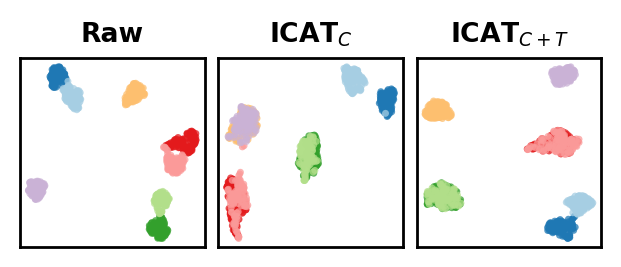

In [19]:
with sns.plotting_context("paper", font_scale=1, rc=rc):
    dot_size = 25
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3.75, 1.25), dpi=200)
    ax = sc.pl.umap(adata, color='Label', palette=stim_palette,
               ax=axes[0], show=False, alpha=0.75, s=dot_size)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('Raw', weight='bold')
    ax.legend_.set_visible(False)
    ax = sc.pl.umap(out1, color='Label', palette=stim_palette,
               ax=axes[1], show=False, alpha=0.75, s=dot_size)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('ICAT$_C$', weight='bold')
    ax.legend_.set_visible(False)
    ax = sc.pl.umap(out2, color='Label', palette=stim_palette,
                   ax=axes[2], show=False, alpha=0.75, s=dot_size)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('ICAT$_{C+T}$', weight='bold')
    ax.legend_.set_visible(False)
    plt.subplots_adjust(wspace=0.075)
plt.savefig('figures/icats.svg', bbox_inches='tight', dpi=200)

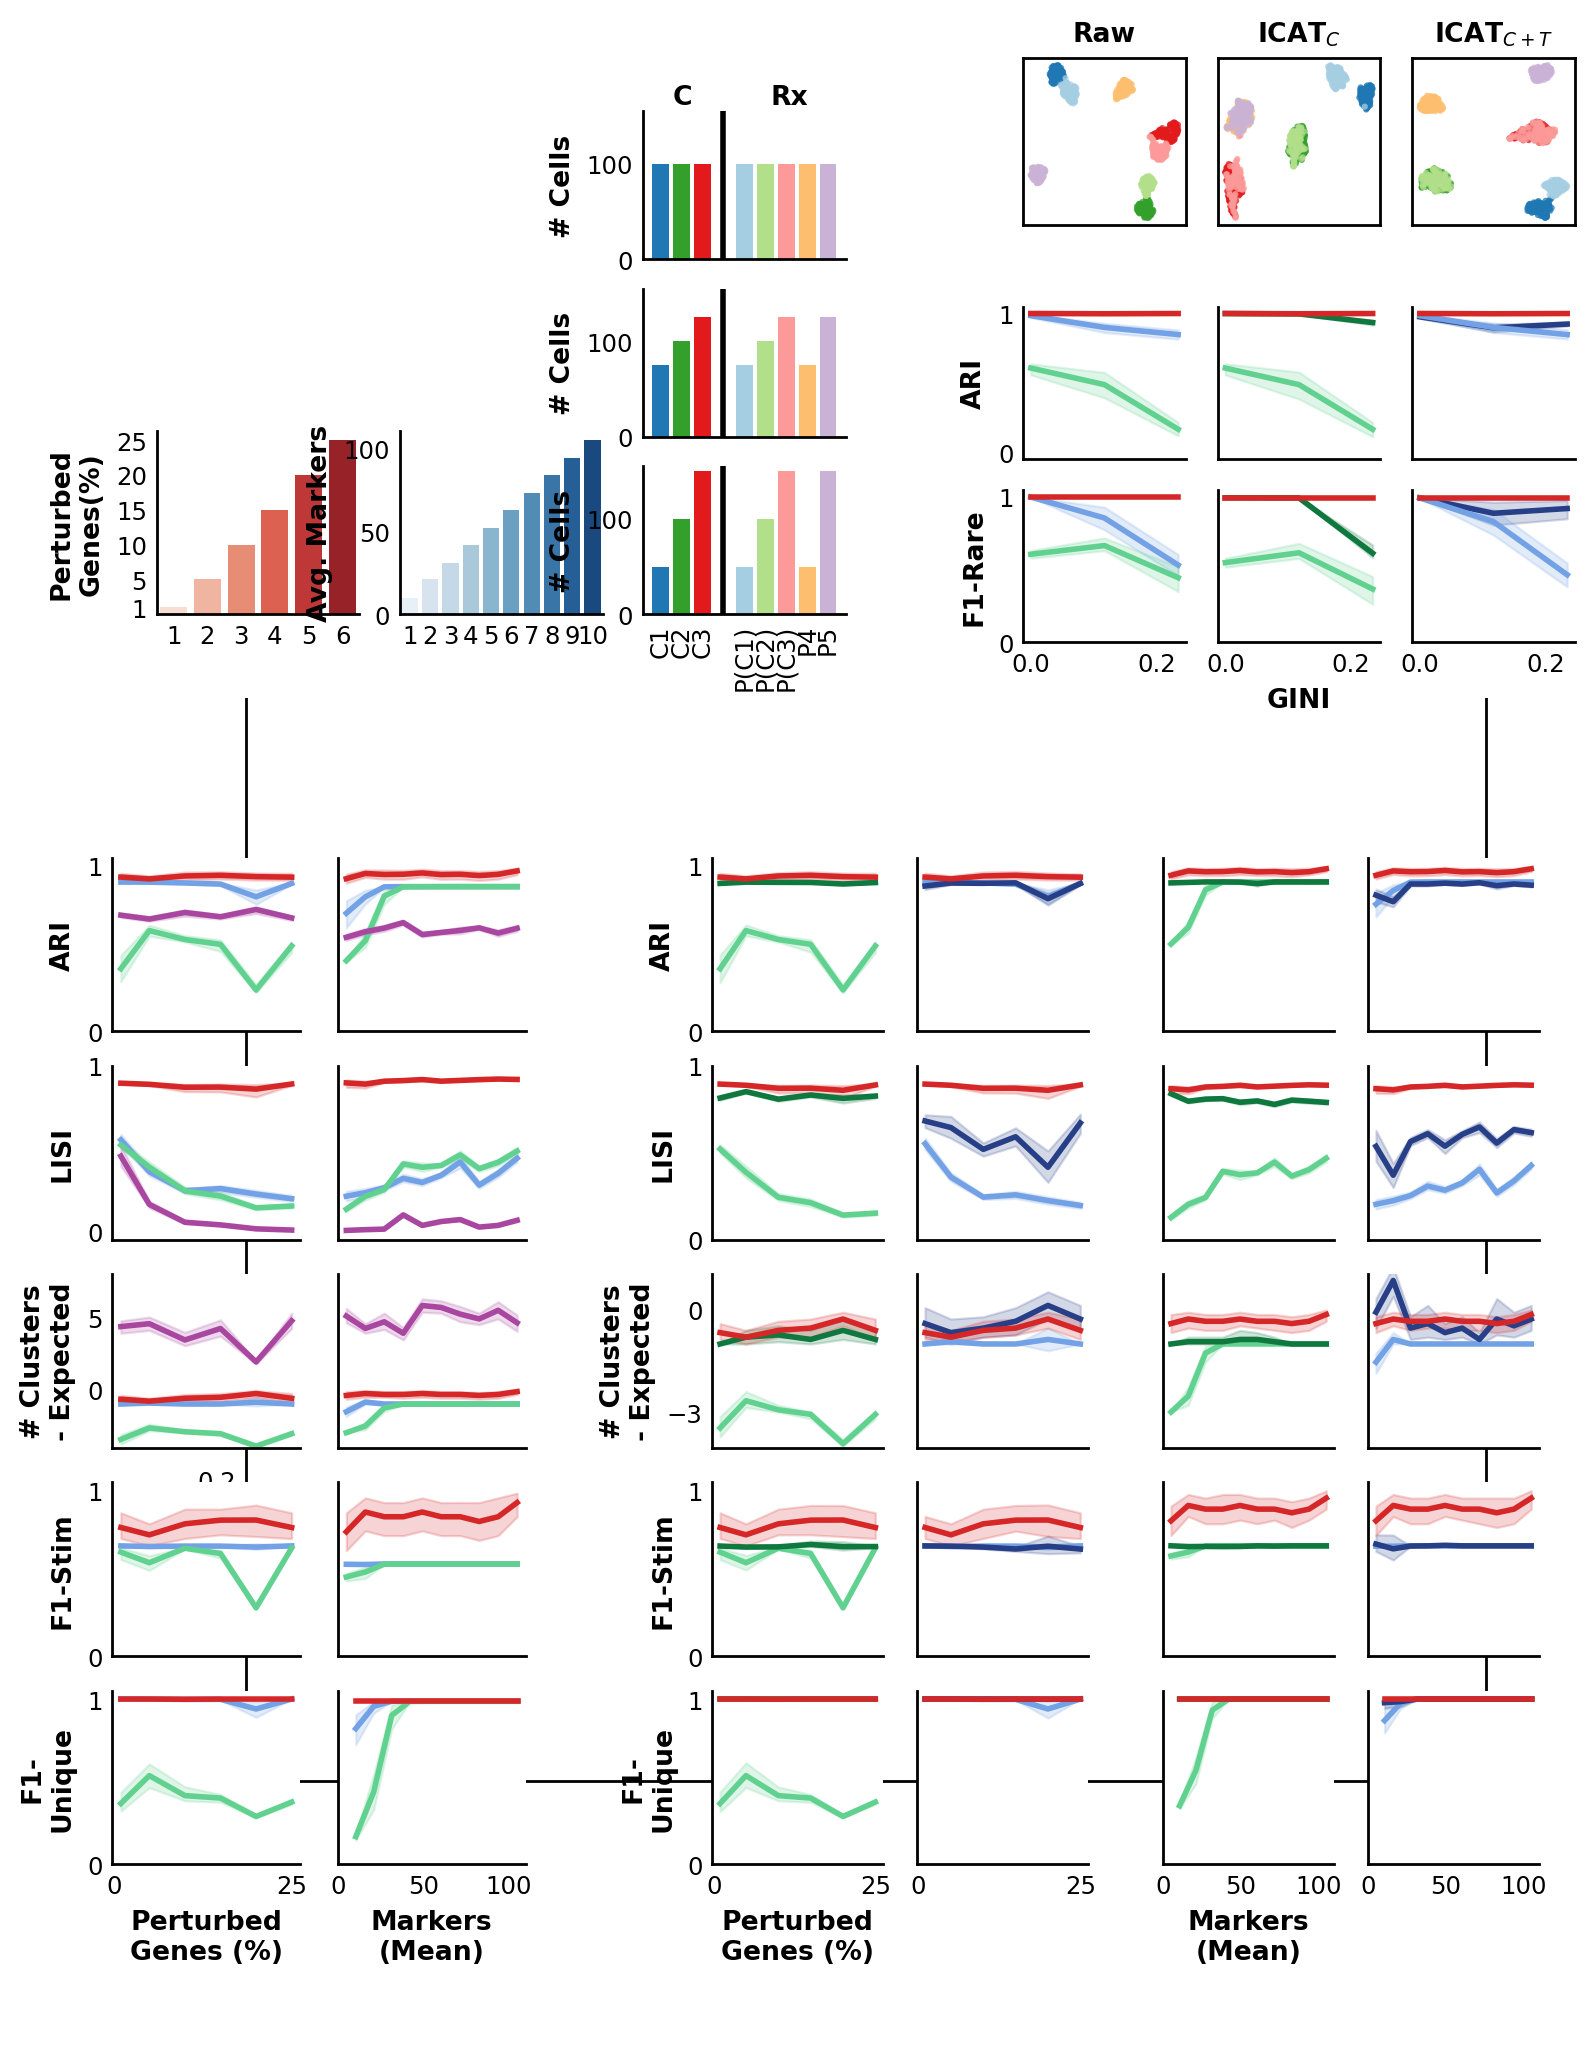

In [20]:
def example_plot(ax, fontsize=12, hide_labels=False):
    pc = ax.pcolormesh(np.random.randn(30, 30), vmin=-2.5, vmax=2.5)
    if not hide_labels:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)
    return pc

rc = {"xtick.major.pad": 0,
      "ytick.major.pad": 0,
      "xtick.major.size": 0,
      "xtick.minor.size": 0,
      "ytick.major.size": 0,
      "ytick.minor.size": 0,
      "lines.linewidth": 2,
      "figure.subplot.left": 0.08,
      "figure.subplot.right": 0.95,
      "figure.subplot.bottom": 0.07,
      "figure.subplot.wspace": 0.25,
      "figure.subplot.hspace": 0.25,
      "legend.labelspacing": 0,
      "legend.handletextpad": 0,
      "legend.columnspacing": 0,
      "font.family": "Helvetica"}

with sns.plotting_context("paper", font_scale=1, rc=rc):
    fig = plt.figure(constrained_layout=False, figsize=(8, 10), dpi=200)
    plt.tick_params(axis='both', which='both', length=0)
    subfigs = fig.subfigures(nrows=2, ncols=1, wspace=0.0,
                             hspace=0.0,
                             height_ratios=[1, 2])
    subfigs[0].set_facecolor('w')
    subfigs[0].set_facecolor('w')


    nested1 = subfigs[0].subfigures(ncols=2, nrows=1,
                                    wspace=0.025,
                                    width_ratios=[1.25, 1])
    nestedx2 = nested1[1].subfigures(ncols=1, nrows=2,
                                     height_ratios=[1, 2])
    # umap
    axes0 = nestedx2[0].subplots(ncols=3, nrows=1)
    for i, (ax, to_plot, title) in enumerate(zip(axes0,
                                                 [adata, out1, out2],
                                                 ['Raw', 'ICAT$_C$', 'ICAT$_{C+T}$'])):
        ax = sc.pl.umap(to_plot, color='Label', palette=stim_palette,
                        ax=ax, show=False, alpha=0.75, frameon=True,
                        s=20)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(title, weight='bold')
        if i in [0, 1, 2]:
            ax.legend_.set_visible(False)
        
    # rare cells

    rare_cell_plot_embedded(formatted, fig=nestedx2[1])
    
    nested2 = subfigs[1].subfigures(ncols=2, nrows=1,
                                    width_ratios=[1, 2])
    signal_pert_plot_extend_embedded(formatted, fig=nested2[1])
    signal_pert_plot_embedded(formatted,
                              metrics=['ARI', 'LISI', 'cluster_dif', 'F1-Stim', 'F1-Unique'],
                              fig=nested2[0])

    gs = nested1[0].add_gridspec(nrows=1, ncols=3)
    gs00 = gs[:, 0].subgridspec(nrows=2, ncols=1, height_ratios=[1.5, 1])

    pdf = pd.DataFrame({'% Perturbed': [1, 5, 10, 15, 20, 25]},
                      index=[i for i in range(1, 7)])
    pdf['Experiment'] = pdf.index.values
    pax = nested1[0].add_subplot(gs00[1])
    pax = sns.barplot(data=pdf, y='% Perturbed', x='Experiment',
                      palette=sns.color_palette('Reds', 6), ax=pax)
    pax.set_yticks([1, 5, 10, 15, 20, 25])
    pax.set_xlabel('')
    pax.set_ylabel('Perturbed\nGenes(%)')
    for spine in ['top', 'right']:
        pax.spines[spine].set_visible(False)

    # plot average number of marker genes
    gs01 = gs[:, 1].subgridspec(nrows=2, ncols=1, height_ratios=[1.5, 1])
    sdf = pd.DataFrame({'Avg # Markers': (np.arange(0.007, 0.077, 0.007) * 1500).astype(int)},
                      index=[i for i in range(1, 11)]) 
    sdf['Experiment'] = sdf.index.values
    sax = nested1[0].add_subplot(gs01[1])
    sax = sns.barplot(data=sdf, y='Avg # Markers', x='Experiment',
                      palette=sns.color_palette('Blues', 10), ax=sax)
    sax.set_xlabel(sax.get_xlabel())
    sax.set_xlabel('')
    sax.set_ylabel("Avg. Markers")
    for spine in ['top', 'right']:
        sax.spines[spine].set_visible(False)
        
    # plot population distributions
    count_max = np.max([x['Cells'].max() for x in dfs])
    gs02 = gs[:, 2].subgridspec(nrows=3, ncols=1)
    specs = [(0, 0), (1, 0), (2, 0)]
    for i, (each, spec) in enumerate(zip(dfs, specs)):
        ax = nested1[0].add_subplot(gs02[spec])
        ax.set_ylim(0, count_max + 5)
        barplot(each, ax)
        if i in [0, 1]:
            ax.set_xticklabels('')
        ax.tick_params(axis='both', which='both', length=0)
        if i == 0:
            ax.annotate('C', (1.75 / 9, 1.05), xycoords='axes fraction',
                        weight='bold',
                        horizontalalignment='center')
            ax.annotate('Rx', (6.5 / 9, 1.05), xycoords='axes fraction',
                        weight='bold',
                        horizontalalignment='center')
    ##########################################
#     plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)
    plt.savefig('figures/main_sim_fig.svg', bbox_inches='tight', dpi=200)
    plt.show()

In [21]:
subfigs = fig.subfigures(2, 2)
print(subfigs)
for i, c in enumerate(['b', 'r', 'y', 'coral']):
    fig = subfigs.flatten()[i]
    fig.set_facecolor(c)
    ax = fig.add_subplot()
    ax.plot([1, 2, 3], [1, 2, 3])
plt.show()

[[<matplotlib.figure.SubFigure object at 0x7f74d3717df0>


In [22]:
formatted.columns
# pert = formatted['Experime']
formatted.rename(columns={'C1+.f1': 'F1-Activated'})
pert = formatted[formatted.Experiment.apply(lambda x: 'Perturbation' in x)]
signal = formatted[formatted.Experiment.apply(lambda x: 'Signal' in x)]
prop = formatted[formatted.Experiment.apply(lambda x: 'Proportion' in x)]
# formatted.Experiment.unique()
6 * 15

90

In [26]:
stim_palette

{'C1': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 'P(C1)+': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'P(C1)': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'C2': (0.2, 0.6274509803921569, 0.17254901960784313),
 'P(C2)': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 'C3': (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 'P(C3)': (0.984313725490196, 0.6039215686274509, 0.6),
 'P4': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 'P5': (0.792156862745098, 0.6980392156862745, 0.8392156862745098)}

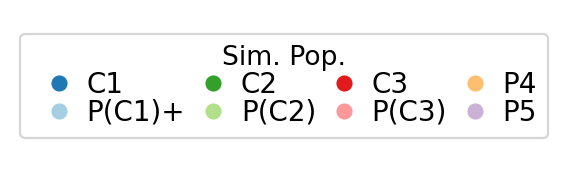

In [77]:
import matplotlib.lines as mlines
rc = {"xtick.major.pad": 0,
      "ytick.major.pad": 0,
      "xtick.major.size": 0,
      "xtick.minor.size": 0,
      "ytick.major.size": 0,
      "ytick.minor.size": 0,
      "lines.linewidth": 2,
      "figure.subplot.left": 0.08,
      "figure.subplot.right": 0.95,
      "figure.subplot.bottom": 0.07,
      "figure.subplot.wspace": 0.25,
      "figure.subplot.hspace": 0.25,
      "legend.labelspacing": 0,
      "legend.handletextpad": 0,
      "legend.columnspacing": 0,
      "font.family": "Helvetica"}
label_order = ['C1', 'P(C1)+', 'C2', 'P(C2)', 'C3', 'P(C3)', 'P4', 'P5']
with sns.plotting_context("paper", font_scale=1.25, rc=rc):
    fig, ax = plt.subplots(figsize=(1,1), dpi=200)
    pop_handles = [mlines.Line2D([], [], color=stim_palette[x], marker='o', linewidth=0,
                             label=x) for x in label_order]
#                              if key!='P(C1)']
    plt.legend(pop_handles, label_order, title="Sim. Pop.",
#                markerscale=1.5,
#                title_fontsize=12,
               fontsize=10,
               ncol=len(pop_handles) // 2,
               columnspacing=0, handletextpad=0, labelspacing=0)
    plt.axis('off')
    plt.savefig('figures/pop_legend.svg', bbox_inches='tight', dpi=200)
    plt.show()
#     ax = plt.subplot()

# pert.groupby(['Experiment', 'Method']).mean()[['Percent Perturbed', 'ARI', 'LISI', 'cluster_dif',
#                                                'F1-Unique', 'F1-Stim']]

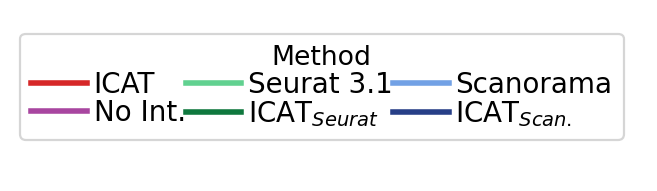

In [107]:
# palette.pop('NCFS + Louvain')
def rename(x):
    if '+' not in x:
        return x
#     return x.replace(' ', '').replace('+', '\n+')
    if 'Scan' in x:
        x='Scan.'
    return "ICAT$_{" + x.split(' ')[0] + '}$'

with sns.plotting_context("paper", font_scale=1.25, rc=rc):
    fig, ax = plt.subplots(figsize=(1,1), dpi=200)
    pop_handles = [mlines.Line2D([], [], color=palette[x], marker='', linewidth=2,
#                                  markersize=5,
                             label=x) for x in palette]
#                              if key!='P(C1)']
    plt.legend(pop_handles, [rename(x) for x in palette.keys()], title="Method",
               markerscale=1.5,
#                title_fontsize=12,
               fontsize=10,
               ncol=len(pop_handles) // 2,
               columnspacing=0, handletextpad=0.25, labelspacing=0)
    plt.axis('off')
    plt.savefig('figures/method_legend.svg', bbox_inches='tight', dpi=200)
    plt.show()